**Análise de Carteira de Seguros – Vendas, Frequência e Prêmio**

Este notebook tem como objetivo analisar uma base de dados transacional do setor de seguros, contendo informações relacionadas a vendas, produtos, filiais, prêmios e sinistros. A base é composta por registros mensais que permitem a avaliação conjunta do desempenho comercial e técnico da carteira ao longo do tempo.

A análise foi estruturada de forma a integrar preparação de dados, construção de indicadores, análise exploratória, visualização e modelagem estatística, garantindo consistência técnica e rastreabilidade dos resultados.


**Objetivo**
O principal objetivo desta análise é avaliar o desempenho comercial e técnico da carteira de seguros ao longo do tempo.

De forma específica, busca-se responder às seguintes questões analíticas:
- Identificar qual filial apresenta tendência de aumento ou queda no custo médio;
- Avaliar quais produtos apresentam tendência de aumento ou queda na frequência de sinistros e no prêmio médio;
- Identificar as filiais com maior volume de vendas mensal;
- Identificar o produto mais vendido em cada mês.


**Dataset**
O dataset utilizado contém informações estruturadas, incluindo:
- Identificação de filial (região);
- Identificação de produto e categoria;
- Datas de referência dos registros;
- Indicadores de vendas (quantidade de registros);
- Informações financeiras, como valor de prêmio e valor de indenização;
- Indicadores de sinistros, como quantidade de sinistros e frequência.

Os dados foram submetidos a etapas de limpeza, padronização de tipos, criação de variáveis temporais e validação de consistência antes da realização das análises.


In [ ]:
#Importação dos pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.linear_model import LinearRegression


## 01: Python – Carregamento e Preparação dos Dados

In [3]:
# Importar o banco de dados
   
df = pd.read_csv('BaseDados.tab', delimiter='\t')

In [4]:
# Visualizando essa base
df.head(5)

,Regiao,Produto,NroApolice,NroItem,Data,Categoria,IS,VlrPremio,QtdSinistros,VlrIndenizacao
0,Banrisul,431,1103431000014,1,07/05/2021,Passeio - Nacional,"43.442,00","1.174,01","0,00","0,00"
1,Banrisul,431,1103431000015,1,07/06/2021,Passeio - Nacional,"34.601,49","844,29","0,00","0,00"
2,Banrisul,431,1103431000016,1,08/06/2021,Pick-Up'S Pesadas (Pessoas),"211.929,30","3.851,10","0,00","0,00"
3,Banrisul,431,1103431000017,1,08/06/2021,Passeio - Nacional,"92.259,09","1.314,06","0,00","0,00"
4,Banrisul,431,1103431000018,1,09/06/2021,Passeio - Nacional,"22.209,66","1.449,21","0,00","0,00"


In [5]:
# Retornando o shape da base
df.shape

(36898, 10)

Dataset: Base de dados com 10 variáveis e 36.898 registros

In [6]:
#Características das variáveis do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36898 entries, 0 to 36897
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Regiao          36898 non-null  object
 1   Produto         36898 non-null  int64 
 2   NroApolice      36898 non-null  int64 
 3   NroItem         36898 non-null  int64 
 4   Data            36898 non-null  object
 5   Categoria       36898 non-null  object
 6   IS              36898 non-null  object
 7   VlrPremio       36898 non-null  object
 8   QtdSinistros    36898 non-null  object
 9   VlrIndenizacao  36898 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.8+ MB


In [7]:
#Transformando a coluna em formado DATA
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['Data'].dtype


dtype('<M8[ns]')

In [8]:
#Transformando a coluna IS em formado float
df['IS'] = (
    df['IS']
    .astype(str)
    .str.replace('.', '', regex=False)   # remove milhar
    .str.replace(',', '.', regex=False)  # troca decimal
)

df['IS'] = pd.to_numeric(df['IS'], errors='coerce')
df['IS'].dtype

dtype('float64')

In [9]:
#Transformando a coluna VlrPremio em formado float
df['VlrPremio'] = (
    df['VlrPremio']
    .astype(str)
    # remove ponto apenas quando for milhar (antes de 3 dígitos)
    .str.replace(r'\.(?=\d{3},)', '', regex=True)
    # troca vírgula decimal por ponto
    .str.replace(',', '.', regex=False)
    .astype(float)
)
df['VlrPremio'].dtype

dtype('float64')

In [10]:
#Transformando a coluna QtdSinistros em formado Int
df['QtdSinistros'] = (
    df['QtdSinistros']
    .astype(str)
    .str.replace('.', '', regex=False)   # remove milhar
    .str.replace(',', '.', regex=False)  # troca decimal
)

df['QtdSinistros'] = pd.to_numeric(df['QtdSinistros'], errors='coerce').astype("Int64")
df['QtdSinistros'].dtype

Int64Dtype()

In [11]:
#Transformando a coluna VlrIndenizacao em formado float
df['VlrIndenizacao'] = (
    df['VlrIndenizacao']
    .astype(str)
    # remove ponto apenas quando for milhar (antes de 3 dígitos)
    .str.replace(r'\.(?=\d{3},)', '', regex=True)
    # troca vírgula decimal por ponto
    .str.replace(',', '.', regex=False)
    .astype(float)
)
df['VlrIndenizacao'].dtype

dtype('float64')

In [12]:
#Características das variáveis trasformadas do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36898 entries, 0 to 36897
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Regiao          36898 non-null  object        
 1   Produto         36898 non-null  int64         
 2   NroApolice      36898 non-null  int64         
 3   NroItem         36898 non-null  int64         
 4   Data            36898 non-null  datetime64[ns]
 5   Categoria       36898 non-null  object        
 6   IS              36898 non-null  float64       
 7   VlrPremio       36898 non-null  float64       
 8   QtdSinistros    36898 non-null  Int64         
 9   VlrIndenizacao  36898 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 2.9+ MB


In [13]:
#Extraindo MesAno da variavel Data
df['MesAno'] = df['Data'].dt.to_period('M').astype(str)
df.head(5)

,Regiao,Produto,NroApolice,NroItem,Data,Categoria,IS,VlrPremio,QtdSinistros,VlrIndenizacao,MesAno
0,Banrisul,431,1103431000014,1,2021-05-07,Passeio - Nacional,43442.00,1174.01,0,0.0,2021-05
1,Banrisul,431,1103431000015,1,2021-06-07,Passeio - Nacional,34601.49,844.29,0,0.0,2021-06
2,Banrisul,431,1103431000016,1,2021-06-08,Pick-Up'S Pesadas (Pessoas),211929.30,3851.10,0,0.0,2021-06
3,Banrisul,431,1103431000017,1,2021-06-08,Passeio - Nacional,92259.09,1314.06,0,0.0,2021-06
4,Banrisul,431,1103431000018,1,2021-06-09,Passeio - Nacional,22209.66,1449.21,0,0.0,2021-06


In [14]:
## Visualizando quantidade de valores vazios por variável
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).head(20)

Regiao            0.0
Produto           0.0
NroApolice        0.0
NroItem           0.0
Data              0.0
Categoria         0.0
IS                0.0
VlrPremio         0.0
QtdSinistros      0.0
VlrIndenizacao    0.0
MesAno            0.0
dtype: float64

In [15]:
#Estatísticas univariadas
df.describe()

,Produto,NroApolice,NroItem,Data,IS,VlrPremio,QtdSinistros,VlrIndenizacao
count,36898.000000,3.689800e+04,36898.000000,36898,36898.000000,36898.000000,36898.0,36898.000000
mean,431.005176,1.105047e+12,1.000542,2021-07-24 22:03:28.011274240,63706.344474,1518.230500,0.054854,697.193097
min,430.000000,1.103431e+12,1.000000,2021-01-01 00:00:00,0.000000,-36.770000,0.0,0.000000
25%,431.000000,1.105431e+12,1.000000,2021-05-17 00:00:00,37149.250000,985.605000,0.0,0.000000
50%,431.000000,1.105431e+12,1.000000,2021-08-02 00:00:00,51609.000000,1330.475000,0.0,0.000000
75%,431.000000,1.105431e+12,1.000000,2021-10-13 00:00:00,78047.000000,1815.480000,0.0,0.000000
max,436.000000,1.105436e+12,2.000000,2021-12-30 00:00:00,436643.900000,22569.000000,4.0,255652.000000
std,0.188283,7.462516e+08,0.023276,NaN,41363.724393,1029.410563,0.27631,6513.944887


## 02: Python – Criação do Banco de Dados SQLite

In [16]:
# Criar banco SQLite
conn = sqlite3.connect('case_hdi.db')

In [17]:
# Gravar tabela
df.to_sql('base', conn, if_exists='replace', index=False)

conn.close()

print("Base carregada com sucesso!")

Base carregada com sucesso!


## 03: SQL – Construção dos Indicadores com CTEs

In [18]:
#Características das variáveis do dataset SQLite
conn = sqlite3.connect('case_hdi.db')

pd.read_sql("PRAGMA table_info(base);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,Regiao,TEXT,0,None,0
1,1,Produto,INTEGER,0,None,0
2,2,NroApolice,INTEGER,0,None,0
3,3,NroItem,INTEGER,0,None,0
4,4,Data,TIMESTAMP,0,None,0
5,5,Categoria,TEXT,0,None,0
6,6,IS,REAL,0,None,0
7,7,VlrPremio,REAL,0,None,0
8,8,QtdSinistros,INTEGER,0,None,0
9,9,VlrIndenizacao,REAL,0,None,0


In [19]:
#Quantidade de linhas
pd.read_sql("SELECT COUNT(*) AS total_linhas FROM base;", conn)


,total_linhas
0,36898


Dataset (BaseDados.tab) com 10 variáveis, 36.898 registros, separado por tabulação (\t), com as emissões por documentos emitidos em 2021.

In [20]:
# Análise das 5 primeiras linhas do dataset
pd.read_sql("""
SELECT
 *
FROM base
LIMIT 5;
""", conn)


,Regiao,Produto,NroApolice,NroItem,Data,Categoria,IS,VlrPremio,QtdSinistros,VlrIndenizacao,MesAno
0,Banrisul,431,1103431000014,1,2021-05-07 00:00:00,Passeio - Nacional,43442.00,1174.01,0,0.0,2021-05
1,Banrisul,431,1103431000015,1,2021-06-07 00:00:00,Passeio - Nacional,34601.49,844.29,0,0.0,2021-06
2,Banrisul,431,1103431000016,1,2021-06-08 00:00:00,Pick-Up'S Pesadas (Pessoas),211929.30,3851.10,0,0.0,2021-06
3,Banrisul,431,1103431000017,1,2021-06-08 00:00:00,Passeio - Nacional,92259.09,1314.06,0,0.0,2021-06
4,Banrisul,431,1103431000018,1,2021-06-09 00:00:00,Passeio - Nacional,22209.66,1449.21,0,0.0,2021-06


In [21]:
#Tabela de Frequencia da variavel Regiao
pd.read_sql("""
SELECT
  Regiao,
  COUNT(*) AS Registros
FROM base
GROUP BY Regiao
ORDER BY Registros DESC;
""", conn)

,Regiao,Registros
0,Sicoob,28650
1,Banrisul,5910
2,Bancos,2338


In [22]:
#Tabela de Frequencia da variavel Produto
pd.read_sql("""
SELECT
  Produto,
  COUNT(*) AS Registros
FROM base
GROUP BY Produto
ORDER BY Registros DESC;
""", conn)

,Produto,Registros
0,431,36789
1,430,59
2,436,50


In [23]:
#Tabela de Frequencia da variavel Categoria
pd.read_sql("""
SELECT
  Categoria,
  COUNT(*) AS Registros
FROM base
GROUP BY Categoria
ORDER BY Registros DESC;
""", conn)

,Categoria,Registros
0,Passeio - Nacional,26812
1,Pick-Up'S Leves - Nacional,5497
2,Pick-Up'S Pesadas (Pessoas),4117
3,Passeio - Estrangeiro,304
4,Pick-Up'S Leves - Estrangeiro,141
5,Pick-Up'S Pesadas (Carga),24
6,Esportivos - Estrangeiro,2
7,Esportivos - Nacional,1


## Etapa Questões abordadas no projeto:

### • 01 – Qual filial apresenta aumento ou queda no custo médio?

In [ ]:
#Query SQL com as informações agrupadas do Dataset utilizando CTE
df_indicadores = pd.read_sql("""
WITH base_agrupada AS (
    SELECT
    Regiao,
    Produto,
    Categoria,
    MesAno,
    COUNT(*) AS qtd_apolices,
    SUM(NroItem) NroItem_total,
    SUM(VlrPremio) AS VlrPremio_total,
    SUM("IS") AS IS_total,
    SUM(QtdSinistros) AS QtdSinistros_total,
    SUM(VlrIndenizacao) AS VlrIndenizacao_total
    
FROM base
GROUP BY Regiao, Produto, Categoria, MesAno
ORDER BY MesAno
),

indicadores AS (
    SELECT
        Regiao,
        MesAno,
        SUM(VlrIndenizacao_total) / NULLIF(SUM(QtdSinistros_total), 0) AS custo_medio,
        CAST(SUM(QtdSinistros_total) AS FLOAT) / NULLIF(SUM(NroItem_total), 0) as frequencia            
    FROM base_agrupada
    GROUP BY Regiao, MesAno
)

SELECT
    Regiao,
    MesAno,
    custo_medio,
    LAG(custo_medio) OVER (PARTITION BY Regiao ORDER BY MesAno) AS custo_medio_anterior,
    custo_medio - LAG(custo_medio) OVER (PARTITION BY Regiao ORDER BY MesAno) AS diferenca_absoluta,
    ROUND(
        (custo_medio / NULLIF(LAG(custo_medio) OVER (PARTITION BY Regiao ORDER BY MesAno), 0) - 1) * 100,
        2
    ) AS variacao_percentual,
    round(frequencia, 2) as frequencia
FROM indicadores
ORDER BY Regiao, MesAno;
""", conn)


,Regiao,MesAno,custo_medio,custo_medio_anterior,diferenca_absoluta,variacao_percentual,frequencia
0,Bancos,2021-01,6455.333333,NaN,NaN,NaN,0.02
1,Bancos,2021-02,30.570000,6455.333333,-6424.763333,-99.53,0.01
2,Bancos,2021-03,3198.303333,30.570000,3167.733333,10362.23,0.02
3,Bancos,2021-04,39659.347778,3198.303333,36461.044444,1140.01,0.07
4,Bancos,2021-05,11443.319286,39659.347778,-28216.028492,-71.15,0.07
5,Bancos,2021-06,13347.718333,11443.319286,1904.399048,16.64,0.05
6,Bancos,2021-07,10906.542632,13347.718333,-2441.175702,-18.29,0.08
7,Bancos,2021-08,6736.613333,10906.542632,-4169.929298,-38.23,0.06
8,Bancos,2021-09,16585.037368,6736.613333,9848.424035,146.19,0.09
9,Bancos,2021-10,15744.346111,16585.037368,-840.691257,-5.07,0.09


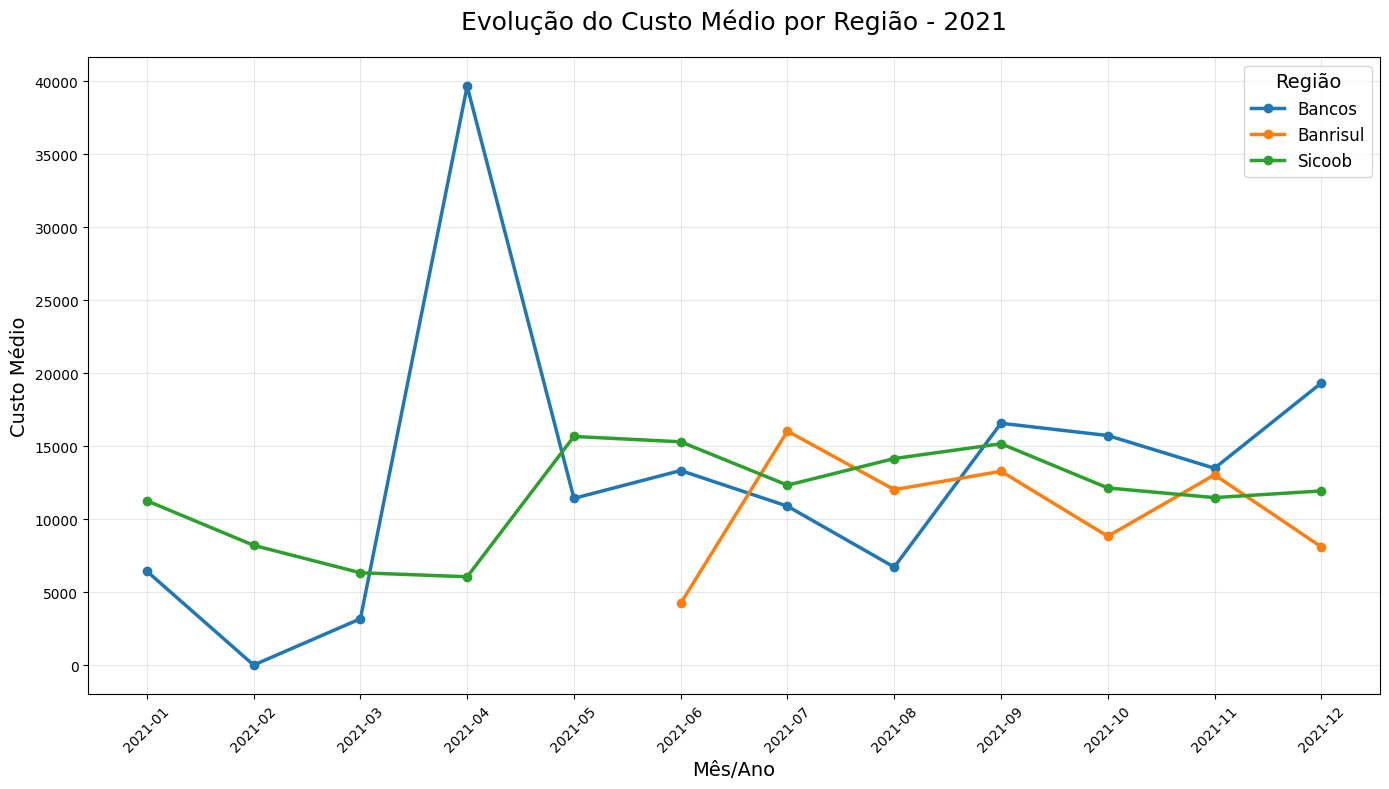

In [26]:
# Gráfico Evolução do Custo Médio Por Região
plt.figure(figsize=(14, 8))

for regiao in df_indicadores['Regiao'].unique():
    subset = df_indicadores[df_indicadores['Regiao'] == regiao]
    plt.plot(subset['MesAno'], subset['custo_medio'], marker='o', label=regiao, linewidth=2.5)

plt.title('Evolução do Custo Médio por Região - 2021', fontsize=18, pad=20)
plt.xlabel('Mês/Ano', fontsize=14)
plt.ylabel('Custo Médio', fontsize=14)
plt.legend(title='Região', fontsize=12, title_fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

In [27]:
#Regressão Linear do Custo Médio por Filial

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def calcula_tendencia(df):
    resultados = []

    for regiao, df_r in df.dropna(subset=['custo_medio']).groupby('Regiao'):
        df_r = df_r.sort_values('MesAno')
        X = np.arange(len(df_r)).reshape(-1, 1)
        y = df_r['custo_medio'].values

        model = LinearRegression().fit(X, y)

        resultados.append({
            'Regiao': regiao,
            'slope_custo_medio': model.coef_[0],
            'slope_percentual_mensal': (model.coef_[0] / y[0]) * 100 if y[0] != 0 else np.nan,
            'custo_medio_inicial': y[0],
            'custo_medio_final': y[-1],
            'variacao_acumulada_%': ((y[-1] - y[0]) / y[0]) * 100 if y[0] != 0 else np.nan
        })

    return pd.DataFrame(resultados)

df_tendencia = calcula_tendencia(df_indicadores)
df_tendencia



,Regiao,slope_custo_medio,slope_percentual_mensal,custo_medio_inicial,custo_medio_final,variacao_acumulada_%
0,Bancos,765.213175,11.853968,6455.333333,19337.548500,199.559256
1,Banrisul,85.476927,2.005556,4262.007143,8117.990896,90.473423
2,Sicoob,403.878468,3.581499,11276.800556,11951.388276,5.982084


01: Qual Filial apresenta aumento ou queda no custo médio:

Resposta: A análise gráfica e de tendência, com base na regressão linear, indica que o custo médio da Filial Bancos apresentou crescimento ao longo do período. O slope positivo do modelo evidencia um aumento médio mensal de aproximadamente R$ 765, caracterizando uma tendência de alta no custo médio.

### • 02 – Qual produto apresenta aumento ou queda na frequência de sinistros ou no prêmio médio ao longo dos meses?

In [32]:
#Query SQL com as informações agrupadas do Dataset utilizando CTE
df_produto = pd.read_sql("""
WITH base_agrupada AS (
    SELECT
    Produto,
    Categoria,
    MesAno,
    COUNT(*) AS qtd_apolices,
    SUM(NroItem) NroItem_total,
    SUM(VlrPremio) AS VlrPremio_total,
    SUM("IS") AS IS_total,
    SUM(QtdSinistros) AS QtdSinistros_total,
    SUM(VlrIndenizacao) AS VlrIndenizacao_total
    
FROM base
GROUP BY Produto, Categoria, MesAno
ORDER BY MesAno
),

indicadores AS (
    SELECT
        Produto,
        MesAno,               
        SUM(VlrPremio_total) / NULLIF(SUM(NroItem_total), 0) AS premio_medio,
        CAST(SUM(QtdSinistros_total) AS FLOAT) / NULLIF(SUM(NroItem_total), 0) as frequencia            
    FROM base_agrupada
    GROUP BY Produto, MesAno
)

SELECT
    Produto,
    MesAno,
    premio_medio,
    round(frequencia, 2) as frequencia
FROM indicadores
ORDER BY Produto, MesAno;
""", conn)

#Dataset Produto = 431
df_produto_431 = df_produto[df_produto['Produto'] == 431]
df_produto_431
df_produto

,Produto,MesAno,premio_medio,frequencia
0,430,2021-01,1060.155000,0.00
1,430,2021-02,1243.070000,0.00
2,430,2021-03,936.037273,0.00
3,430,2021-04,1040.010000,0.00
4,430,2021-05,924.026667,0.00
5,430,2021-06,1273.726000,0.00
6,430,2021-07,795.390000,0.00
7,430,2021-08,755.188750,0.00
8,430,2021-09,1172.880000,0.00
9,430,2021-10,852.054000,0.00


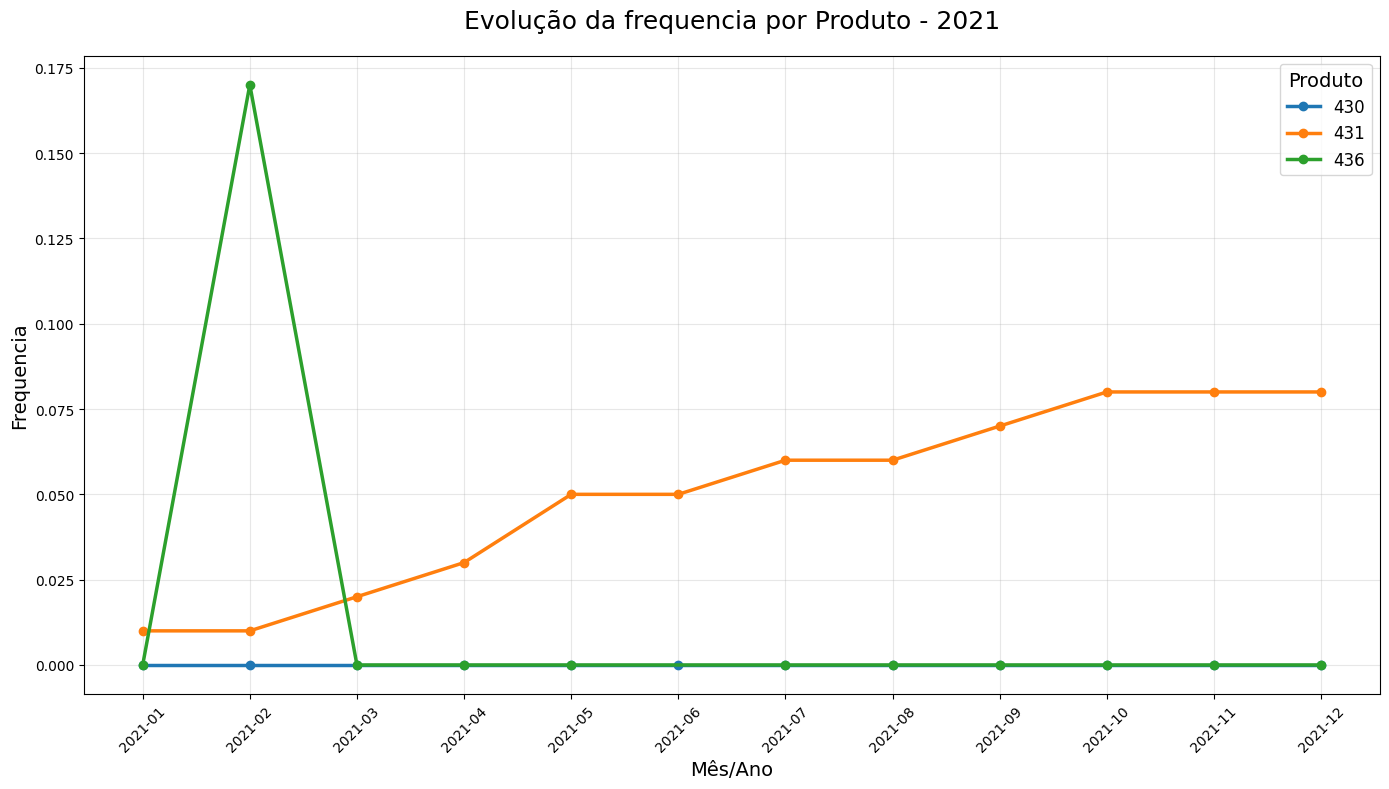

In [29]:
# Gráfico Evolução da Frequencia por Produto
plt.figure(figsize=(14, 8))

for produto in df_produto['Produto'].unique():
    subset = df_produto[df_produto['Produto'] == produto]
    plt.plot(subset['MesAno'], subset['frequencia'], marker='o', label=produto, linewidth=2.5)

plt.title('Evolução da frequencia por Produto - 2021', fontsize=18, pad=20)
plt.xlabel('Mês/Ano', fontsize=14)
plt.ylabel('Frequencia', fontsize=14)
plt.legend(title='Produto', fontsize=12, title_fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

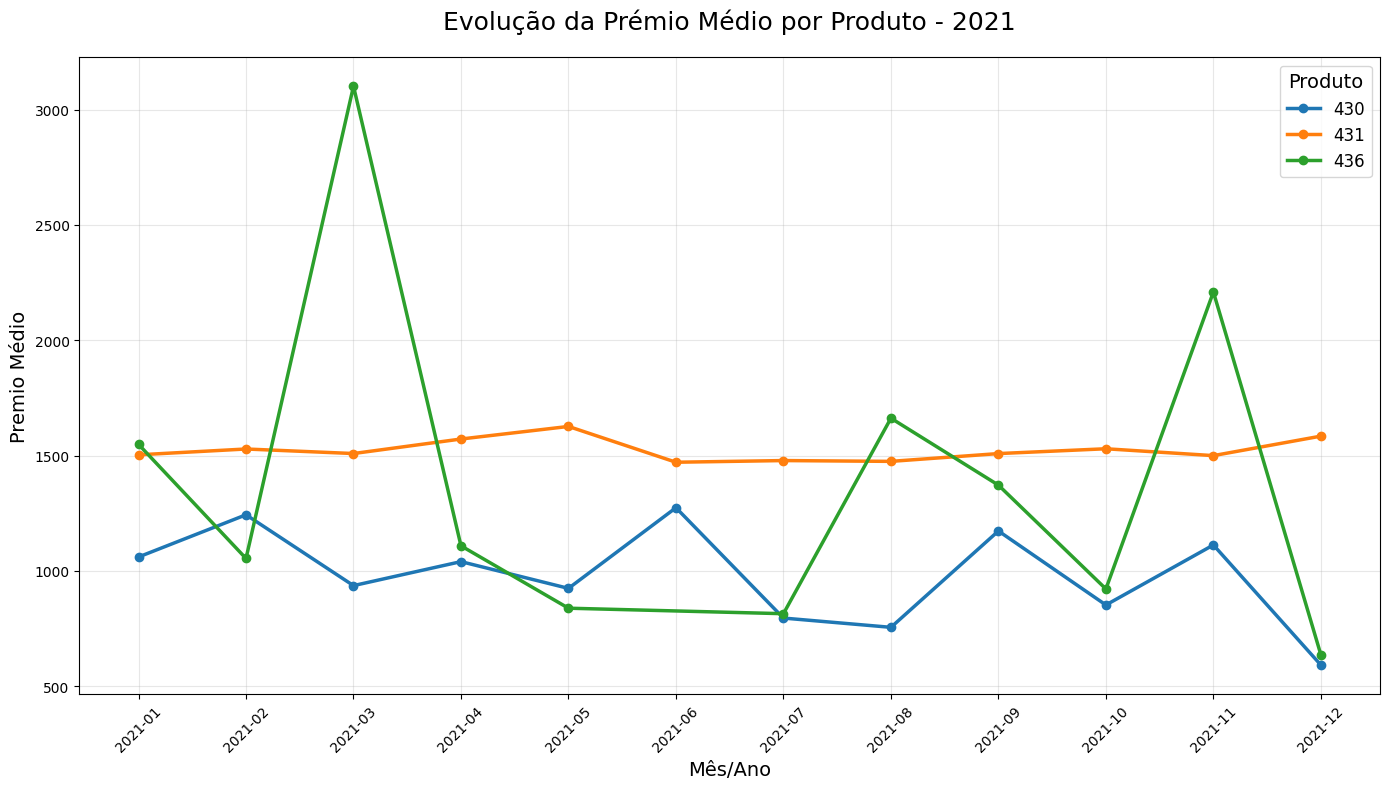

In [30]:
# Gráfico Evolução do Prêmio Médio por Produto
plt.figure(figsize=(14, 8))

for produto in df_produto['Produto'].unique():
    subset = df_produto[df_produto['Produto'] == produto]
    plt.plot(subset['MesAno'], subset['premio_medio'], marker='o', label=produto, linewidth=2.5)

plt.title('Evolução da Prémio Médio por Produto - 2021', fontsize=18, pad=20)
plt.xlabel('Mês/Ano', fontsize=14)
plt.ylabel('Premio Médio', fontsize=14)
plt.legend(title='Produto', fontsize=12, title_fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

In [33]:
#Regressão Linear do Custo Médio por Filial
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def calcula_tendencia_produto(df):
    resultados = []

    for produto, df_r in df.dropna(subset=['premio_medio']).groupby('Produto'):
        df_r = df_r.sort_values('MesAno')

        # eixo temporal correto
        X = np.arange(len(df_r)).reshape(-1, 1)
        y = df_r['premio_medio'].values

        model = LinearRegression().fit(X, y)

        resultados.append({
            'Produto': produto,
            'slope_premio_medio': model.coef_[0],  # R$/mês
            'slope_percentual_mensal': (model.coef_[0] / y[0]) * 100 if y[0] != 0 else np.nan,
            'premio_medio_inicial': y[0],
            'premio_medio_final': y[-1],
            'variacao_acumulada_%': ((y[-1] - y[0]) / y[0]) * 100 if y[0] != 0 else np.nan
        })

    return pd.DataFrame(resultados)

# Executa apenas para o Produto 431
df_tendencia_produto = calcula_tendencia_produto(df_produto_431)
df_tendencia_produto


,Produto,slope_premio_medio,slope_percentual_mensal,premio_medio_inicial,premio_medio_final,variacao_acumulada_%
0,431,0.053539,0.003562,1503.021521,1584.082591,5.393208


02: Produto que demonstre queda ou aumento na frequência ou aumento/queda do prêmio médio ao longo dos meses:

Resposta:

O Produto 431 apresentou aumento consistente da frequência de sinistros ao longo do período, enquanto o prêmio médio manteve-se predominantemente estável.

A regressão linear do prêmio médio foi aplicada exclusivamente a esse produto, por ser o único com série temporal consistente e frequência de sinistros diferente de zero ao longo do período analisado. Nos demais produtos, a frequência praticamente nula inviabiliza a análise de tendência.

Embora o prêmio médio do Produto 431 tenha apresentado aumento acumulado no período, o slope da regressão linear é positivo, porém muito baixo, indicando ausência de tendência relevante de alta ou queda, caracterizando estabilidade do prêmio médio.

### • 03 – Quais filiais mais venderam por mês?

In [34]:
#Query SQL com as informações agrupadas do Dataset utilizando CTE
df_vendas_filial = pd.read_sql("""
WITH vendas_filial AS (
    SELECT
        MesAno,
        Regiao AS Filial,
        COUNT(*) AS qtd_vendas
    FROM base
    GROUP BY MesAno, Regiao
),
ranking AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY MesAno ORDER BY qtd_vendas DESC) AS rn
    FROM vendas_filial
)
SELECT
    MesAno,
    Filial,
    qtd_vendas
FROM ranking
WHERE rn = 1
ORDER BY MesAno;
""", conn)

df_vendas_filial




,MesAno,Filial,qtd_vendas
0,2021-01,Sicoob,2133
1,2021-02,Sicoob,2016
2,2021-03,Sicoob,1908
3,2021-04,Sicoob,1551
4,2021-05,Sicoob,1999
5,2021-06,Sicoob,2823
6,2021-07,Sicoob,2978
7,2021-08,Sicoob,2698
8,2021-09,Sicoob,2823
9,2021-10,Sicoob,2974


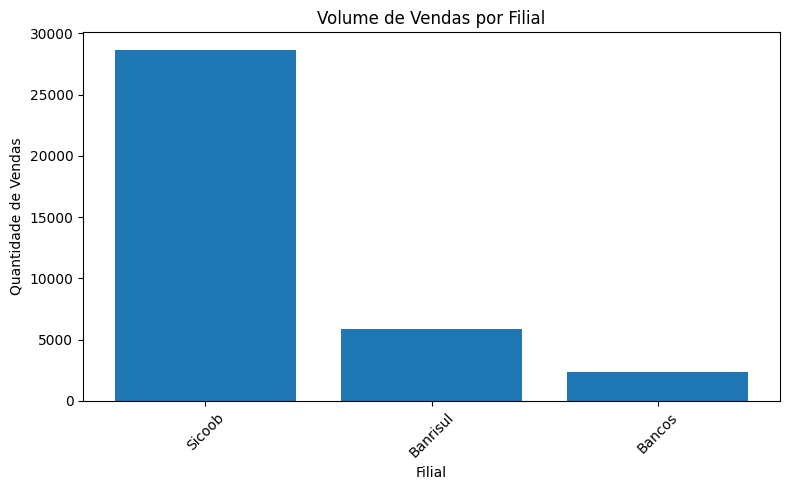

In [35]:
# Gráfico Volume de Vendas por Filial

df_vendas_filial_group = pd.read_sql("""
SELECT
  Regiao,
  COUNT(*) AS Registros
FROM base
GROUP BY Regiao
ORDER BY Registros DESC;
""", conn)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(
    df_vendas_filial_group['Regiao'],
    df_vendas_filial_group['Registros']
)

plt.xlabel('Filial')
plt.ylabel('Quantidade de Vendas')
plt.title('Volume de Vendas por Filial')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


03: Quais filiais mais venderam por mês

Resposta: Ao longo de todos os meses analisados, a filial Sicoob foi a que apresentou o maior volume de vendas, mantendo liderança consistente mês a mês

### • 04 – Qual produto foi o mais vendido em cada mês?

In [36]:
#Query SQL com as informações agrupadas do Dataset utilizando CTE
df_vendas_produto = pd.read_sql("""
WITH vendas_produto AS (
    SELECT
        MesAno,
        Produto,
        COUNT(*) AS qtd_vendas
    FROM base
    GROUP BY MesAno, Produto
),
ranking AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY MesAno ORDER BY qtd_vendas DESC) AS rn
    FROM vendas_produto
)
SELECT
    MesAno,
    Produto,
    qtd_vendas
FROM ranking
WHERE rn = 1
ORDER BY MesAno;

""", conn)

df_vendas_produto




,MesAno,Produto,qtd_vendas
0,2021-01,431,2308
1,2021-02,431,2189
2,2021-03,431,2047
3,2021-04,431,1663
4,2021-05,431,2179
5,2021-06,431,3223
6,2021-07,431,3979
7,2021-08,431,3816
8,2021-09,431,3926
9,2021-10,431,4106


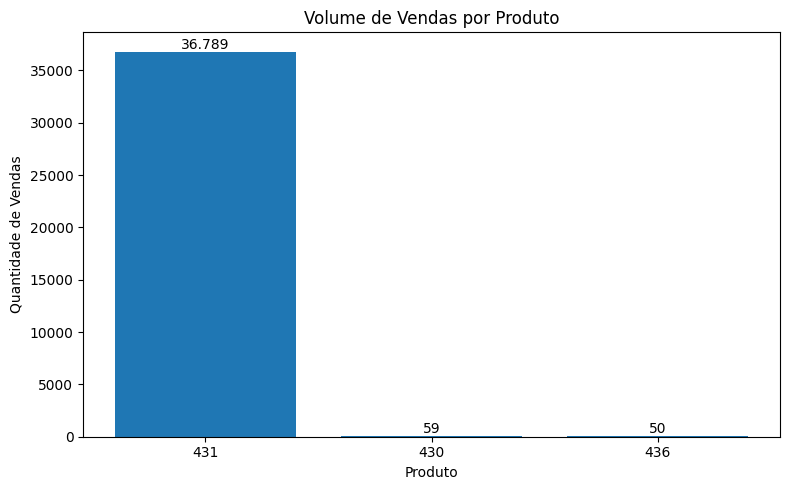

In [37]:
# Gráfico Volume de Vendas por Produto

df_vendas_produto_group = pd.read_sql("""
SELECT
  Produto,
  COUNT(*) AS Registros
FROM base
GROUP BY Produto
ORDER BY Registros DESC;
""", conn)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

bars = plt.bar(
    df_vendas_produto_group['Produto'].astype(str),
    df_vendas_produto_group['Registros']
)

plt.xlabel('Produto')
plt.ylabel('Quantidade de Vendas')
plt.title('Volume de Vendas por Produto')

# Ajusta o eixo Y
plt.ylim(bottom=0)

# Adiciona os valores acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}'.replace(',', '.'),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


04: Qual produto mais vendido a cada mês

Resposta: A análise do volume de vendas por produto indica que o Produto 431 liderou as vendas em todos os meses do período analisado. Observa-se aumento do volume a partir do segundo semestre, com destaque para os meses de julho a outubro

# FIM